<a href="https://colab.research.google.com/github/yuguerten/CNN-ImageClassifier/blob/master/imageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Dependencies**

In [61]:
!pip install tensorflow matplotlib opencv-python

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [63]:
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
except ValueError:
  strategy = tf.distribute.get_strategy()

**remove doddgy images**

In [64]:
import imghdr
import os

In [65]:
data_dir = '/content/data'

In [66]:
img_exts = ['jpeg','jpg','bmp','png']

In [67]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

**Load Data**

In [68]:
data = tf.keras.utils.image_dataset_from_directory('/content/data') #Creating a dataset from image files in the specified directory

Found 262 files belonging to 2 classes.


In [69]:
data_iterator = data.as_numpy_iterator() #into numpy arrays

In [70]:
batch = data_iterator.next()

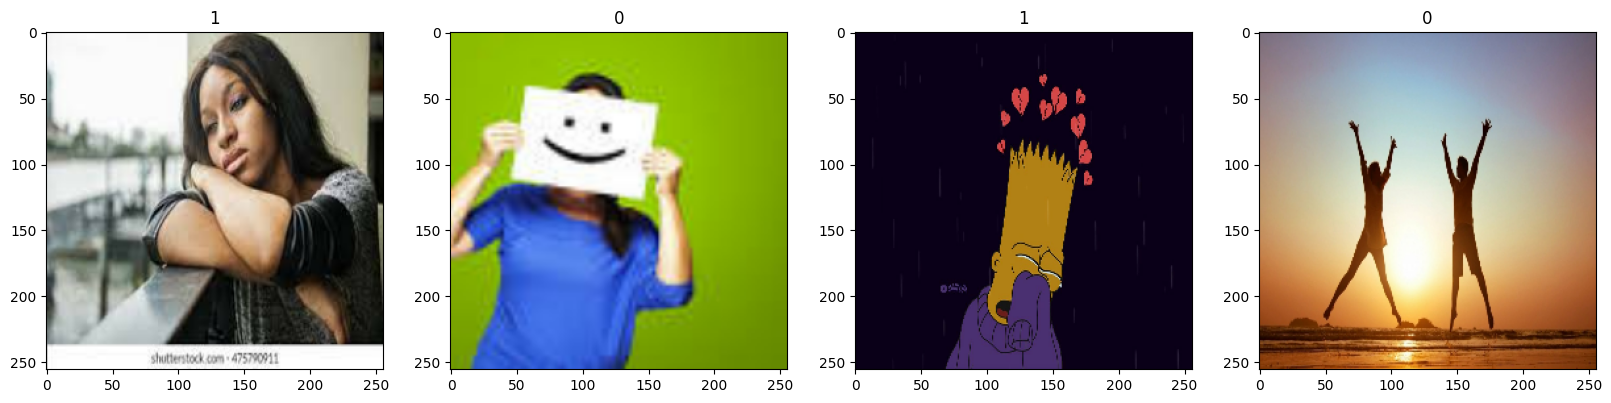

In [71]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**Applying normalization to the images in the dataset**

In [72]:
data =  data.map(lambda x, y: (x/255, y))

In [73]:
data.as_numpy_iterator().next()

(array([[[[4.5490196e-01, 4.0784314e-01, 3.1372550e-01],
          [4.5536152e-01, 4.0830269e-01, 3.1418505e-01],
          [4.5882353e-01, 4.1176471e-01, 3.1764707e-01],
          ...,
          [4.5490196e-01, 4.3529412e-01, 3.2156864e-01],
          [4.5490196e-01, 4.3529412e-01, 3.2156864e-01],
          [4.5490196e-01, 4.3529412e-01, 3.2156864e-01]],
 
         [[4.5490196e-01, 4.0784314e-01, 3.1372550e-01],
          [4.5536152e-01, 4.0830269e-01, 3.1418505e-01],
          [4.5882353e-01, 4.1176471e-01, 3.1764707e-01],
          ...,
          [4.5714614e-01, 4.3753830e-01, 3.2381281e-01],
          [4.5714614e-01, 4.3753830e-01, 3.2381281e-01],
          [4.5714614e-01, 4.3753830e-01, 3.2381281e-01]],
 
         [[4.5490196e-01, 4.0784314e-01, 3.1372550e-01],
          [4.5536152e-01, 4.0830269e-01, 3.1418505e-01],
          [4.5882353e-01, 4.1176471e-01, 3.1764707e-01],
          ...,
          [4.5972955e-01, 4.3830967e-01, 3.2549021e-01],
          [4.5994943e-01, 4.3808976e-

**split the data (train,test,val)**

In [74]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [75]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

**Build the model**

In [76]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout

In [77]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (3,3), 1, activation='relu'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(16, (3,3), 1, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Flatten(),
keras.layers.Dense(256, activation='relu'),
keras.layers.Dense(1, activation ='sigmoid')])

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 dropout_3 (Dropout)         (None, 60, 60, 16)       

In [79]:
model.compile(loss = 'binary_crossentropy',optimizer='adam', metrics = ['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)

In [80]:
model.fit(train, epochs=20, validation_data=val, callbacks=callback)

Epoch 1/20
6/6 [==============================] - 4s 381ms/step - loss: 1.2786 - accuracy: 0.5156 - val_loss: 0.6650 - val_accuracy: 0.6875
Epoch 2/20
6/6 [==============================] - 2s 207ms/step - loss: 0.6985 - accuracy: 0.5469 - val_loss: 0.6629 - val_accuracy: 0.5625
Epoch 3/20
6/6 [==============================] - 3s 483ms/step - loss: 0.6519 - accuracy: 0.6615 - val_loss: 0.6131 - val_accuracy: 0.7812
Epoch 4/20
6/6 [==============================] - 4s 373ms/step - loss: 0.6255 - accuracy: 0.7448 - val_loss: 0.5819 - val_accuracy: 0.6875
Epoch 5/20
6/6 [==============================] - 3s 384ms/step - loss: 0.5760 - accuracy: 0.7396 - val_loss: 0.5468 - val_accuracy: 0.8438
Epoch 6/20
6/6 [==============================] - 4s 623ms/step - loss: 0.5153 - accuracy: 0.8021 - val_loss: 0.4808 - val_accuracy: 0.7188
Epoch 7/20
6/6 [==============================] - 5s 606ms/step - loss: 0.3829 - accuracy: 0.8333 - val_loss: 0.4903 - val_accuracy: 0.7188
Epoch 8/20
6/6 [====

In [81]:
loss, accuracy = model.evaluate(val)
print("Loss:", loss)
print("Accuracy:", accuracy)

1/1 [==============================] - 1s 614ms/step - loss: 0.0820 - accuracy: 1.0000
Loss: 0.08200095593929291
Accuracy: 1.0


**test**

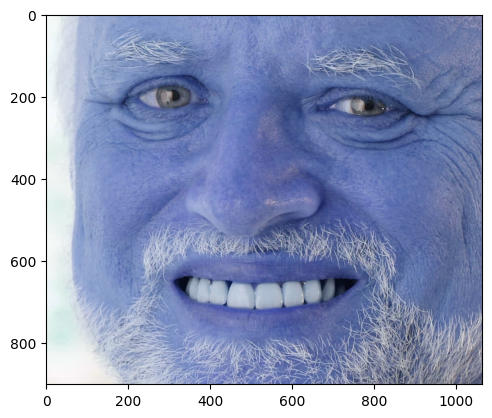

In [82]:
img = cv2.imread('/content/funny-old-man-pictures-29zq8pp6pi1gcap8.jpg')
plt.imshow(img)
plt.show()

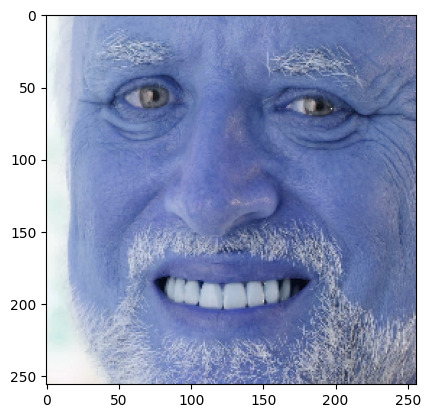

In [83]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [84]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 132ms/step


In [85]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
